In [1]:
from astropy.stats import LombScargle
import rafias_lib as rl
import everett_code as ec
from astropy.io import fits, ascii
from astropy.table import Table
from astropy.time import Time
import numpy as np
import pdb, glob, os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
filenames_a1 = glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'+
                              '/NRCN821WLP8SUB-6012134600_1_481_SE_2016-01-12T16h42m53/*.slp.fits')

In [3]:
filenames_b4 = glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'+
                              '/NRCN821WLP8SUB-*_489_SE_*/*.slp.fits')[:306]

In [4]:
centers_a1 = rl.gen_center_g2d(166, 160, 5, 400, 2, 2, 0, filenames_a1)

In [5]:
centers_b4 = rl.gen_center_g2d(162, 156, 5, 500, 2, 2, 0, filenames_b4)

In [ ]:
rt_table = rl.radius_testing(centers_a1[0], 10, 110, 5, 20, 120, 5, 30, 130, 5, filenames_a1)

In [ ]:
rt_table.write('rt_320_for_jf.csv')

In [ ]:
plt.plot(rt_table['r_source'], rt_table['norm_stdev'])

In [ ]:
#a1 time series
a1_ts = rl.time_series(centers_a1[1], centers_a1[2], filenames_a1, 70, 72, 80)

In [ ]:
#b4 time series
b4_ts = rl.time_series(centers_b4[1], centers_b4[2], filenames_b4, 70, 72, 80)

In [ ]:
a1_cen_pos = np.sqrt(np.square(centers_a1[1]) + np.square(centers_a1[2]))
b4_cen_pos = np.sqrt(np.square(centers_b4[1]) + np.square(centers_b4[2]))

In [ ]:
plt.figure(figsize = (10,6))
plt.subplot(1,2,1)
plt.plot(a1_ts['time'], a1_cen_pos, 'o', label = 'a1 center positions')
plt.legend(loc = 'best')
plt.title('Center position (radial coordinates) Vs. Time')
plt.subplot(1,2,2)
plt.plot(b4_ts['time'], b4_cen_pos, 'ro', label = 'b4 center positions')
plt.legend(loc = 'best')
plt.title('Center position (radial coordinates) Vs. Time')

plt.tight_layout()

In [ ]:
plt.figure(figsize = (10,8))
rl.light_curve(a1_ts['time'], a1_ts['res_flux'], style = 'b-', lbl = 'a1 series')
rl.light_curve(b4_ts['time'], b4_ts['res_flux'], style = 'g-', lbl = 'b4 series')
rl.light_curve(a1_ts['time'], (a1_ts['res_flux']+b4_ts['res_flux'])/2, style = 'r-', lbl = 'Averaged series')
plt.legend(loc = 'best')
plt.title('Light curves without linear bestfit')

In [ ]:
detrended_a1 = rl.linear_bestfit(a1_ts['time'], a1_ts['res_flux'], 0.00002, 1)
detrended_b4 = rl.linear_bestfit(b4_ts['time'], b4_ts['res_flux'], 0.00002, 1)

In [ ]:
plt.figure(figsize = (10,8))
rl.light_curve(a1_ts['time'], detrended_a1, style = 'b-', lbl = 'a1 series')
rl.light_curve(b4_ts['time'], detrended_b4, style = 'g-', lbl = 'b4 series')
rl.light_curve(a1_ts['time'], (detrended_a1+detrended_b4)/2, style = 'r-', lbl = 'Averaged series')
plt.legend(loc = 'best')
plt.title('Light curves with linear bestfit')

## Detector Ramps

In [8]:
fname_a1 = glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'+
                              '/NRCN821WLP8SUB-6012134600_1_481_SE_2016-01-12T16h42m53/*.red.fits')

In [9]:
fname_b4 = glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'+
                              '/NRCN821WLP8SUB-*_489_SE_*/*.red.fits')[:306]

In [9]:
hdu = fits.open(fname_a1[150])
header = hdu[0].header
image = hdu[0].data
time = np.arange(1, header['NGROUP']+2, header['TGROUP'])
len(time), len(image[:, 160, 160])

(20, 20)

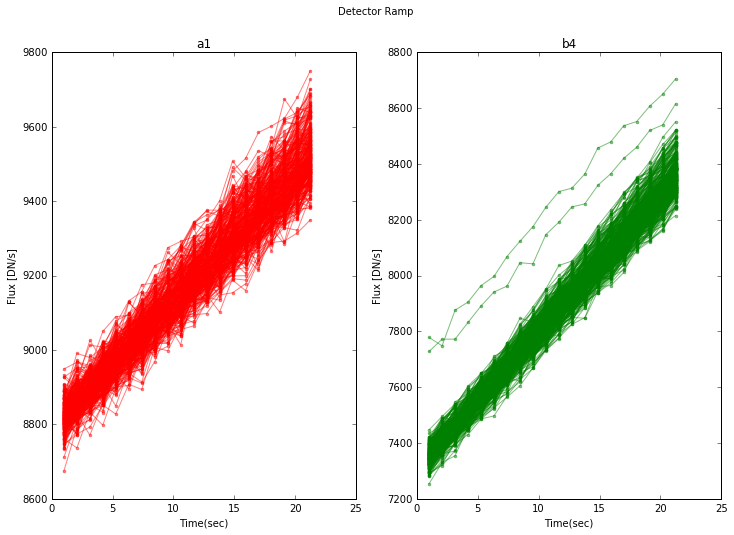

In [7]:
plt.figure(figsize = (12,8))
for a1, b4 in zip (fname_a1, fname_b4):
    
    hdu_a1 = fits.open(a1)
    hdu_b4 = fits.open(b4)
    
    hdr_a1 = hdu_a1[0].header
    hdr_b4 = hdu_b4[0].header
    
    image_a1 = hdu_a1[0].data
    image_b4 = hdu_b4[0].data
    
    time_a1 = np.arange(1, hdr_a1['NGROUP']+2, hdr_a1['TGROUP'])
    time_b4 = np.arange(1, hdr_b4['NGROUP']+2, hdr_b4['TGROUP'])
    
    plt.subplot(121)
    plt.plot(time_a1, image_a1[:, 166, 165], 'r.-', alpha = 0.5)
    plt.xlabel('Time(sec)')
    plt.ylabel('Flux [DN/s]')
    plt.title('a1')
    plt.subplot(122)
    plt.plot(time_b4, image_b4[:, 162, 156], 'g.-', alpha = 0.5)
    plt.xlabel('Time(sec)')
    plt.ylabel('Flux [DN/s]')
    plt.title('b4')
    
    hdu_a1.close()
    hdu_b4.close()

plt.xlabel('Time(sec)')
plt.ylabel('Flux [DN/s]')
plt.suptitle('Detector Ramp')

# High Frequency Time Series & Periodogram

In [10]:
check = Table(names = ('ON_NINT', 'planes', 't_slope', '#plane'), dtype = ('i8', 'S16', 'f8', 'f8'))
for i, (a1, b4) in enumerate(zip(fname_a1, fname_b4)):
    
    hdu_a1 = fits.open(a1)
    hdu_b4 = fits.open(b4)
    
    image_a1 = hdu_a1[0].data
    image_b4 = hdu_b4[0].data
    
    header_a1 = hdu_a1[0].header
    header_b4 = hdu_b4[0].header
    
    offset_str_a1 = header_a1['DATE-OBS']+'T'+header_a1['TIME-OBS']
    offset_a1 = Time(offset_str_a1).jd
    
    offset_str_b4 = header_b4['DATE-OBS']+'T'+header_b4['TIME-OBS']
    offset_b4 = Time(offset_str_b4).jd
    
    for j in range(header_a1["NGROUP"]-1):
        t_slope_a1 = (offset_a1 + ((header_a1["NGROUP"] + 1) * header_a1['TGROUP']* (header_a1["ON_NINT"] - 1)) + 
                      (header_a1['TGROUP']*j) + header_a1['TFRAME'])
        t_slope_b4 = (offset_b4 + ((header_b4["NGROUP"] + 1) * header_b4['TGROUP']* (header_b4["ON_NINT"] - 1)) + 
                      (header_b4['TGROUP']*j) + header_b4['TFRAME'])        
        header_a1['t_slope'] = t_slope_a1
        header_b4['t_slope'] = t_slope_b4 
        plane_a1 = (image_a1[j+1] - image_a1[j])/t_slope_a1
        plane_b4 = (image_b4[j+1] - image_b4[j])/t_slope_b4
        check.add_row([header_a1['ON_NINT'], 'p%i - p%i' % (j+1, j), (t_slope_a1 - offset_a1), j])
        pathname_a1 = 'WLP8SUB_a1_planes/a1_im%03i_plane%02i.slp.fits' % (i, j)
        pathname_b4 = 'WLP8SUB_b4_planes/b4_im%03i_plane%02i.slp.fits' % (i, j)
        fits.writeto(pathname_a1, plane_a1, header = header_a1, overwrite = True)
        fits.writeto(pathname_b4, plane_b4, header = header_b4, overwrite = True)
    hdu_a1.close()
    hdu_b4.close()
check

ON_NINT,planes,t_slope,#plane
int64,str16,float64,float64
1,p1 - p0,1.06571999984,0.0
1,p2 - p1,2.13143999968,1.0
1,p3 - p2,3.19715999998,2.0
1,p4 - p3,4.26287999982,3.0
1,p5 - p4,5.32859999966,4.0
1,p6 - p5,6.39431999996,5.0
1,p7 - p6,7.4600399998,6.0
1,p8 - p7,8.52575999964,7.0
1,p9 - p8,9.59147999994,8.0


In [11]:
a1_files = np.sort(glob.glob('WLP8SUB_a1_planes/a1*.fits'))
b4_files = np.sort(glob.glob('WLP8SUB_b4_planes/b4*.fits'))
len(a1_files), len(a1_files)

(5814, 5814)

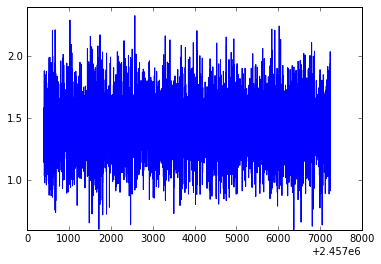

In [12]:
a1_flux = []
b4_flux = []

a1_time = []
b4_time = []

mask_a1 = rl.test_image(fname_a1[2])[3]
mask_b4 = rl.test_image(fname_b4[2])[3]

for i, (a1, b4) in enumerate(zip(a1_files, b4_files)):
    
    image_a1 = fits.getdata(a1)
    a1_flux.append(rl.photometry(image_a1, [166], [160], mask_a1, rad = 70)[0])
    a1_time.append(fits.getheader(a1)['t_slope'])
    
    image_b4 = fits.getdata(b4)
    b4_flux.append(rl.photometry(image_b4, [162], [156], mask_b4, rad = 70)[0])
    b4_time.append(fits.getheader(b4)['t_slope'])
    
#     pdb.set_trace()
    
plt.plot(a1_time, a1_flux)
# plt.plot(b4_time, b4_flux)

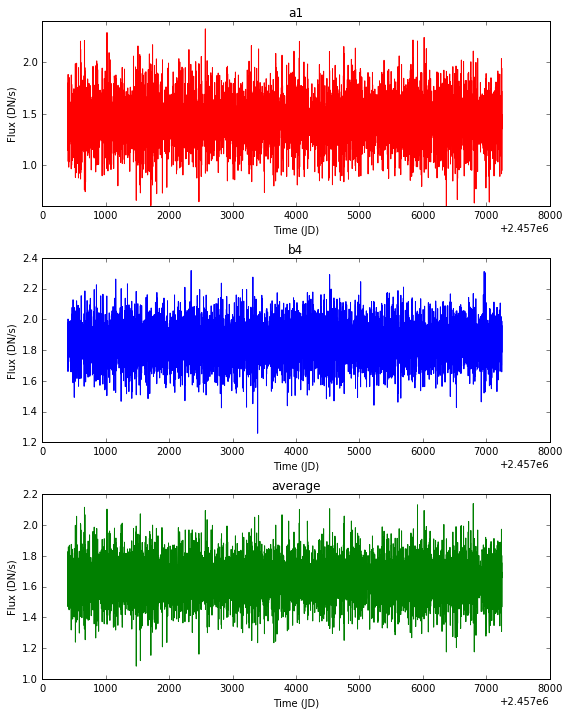

In [13]:
plt.figure(figsize=(8, 10))
plt.subplot(311)
plt.plot(a1_time, a1_flux, 'r')
plt.title('a1')
plt.xlabel('Time (JD)')
plt.ylabel('Flux (DN/s)')
plt.subplot(312)
plt.plot(b4_time, b4_flux, 'b')
plt.title('b4')
plt.xlabel('Time (JD)')
plt.ylabel('Flux (DN/s)')
plt.subplot(313)
av = (np.array(a1_flux) + np.array(b4_flux))/2.
plt.plot(b4_time, av, 'g')
plt.title('average')
plt.xlabel('Time (JD)')
plt.ylabel('Flux (DN/s)')
plt.tight_layout()

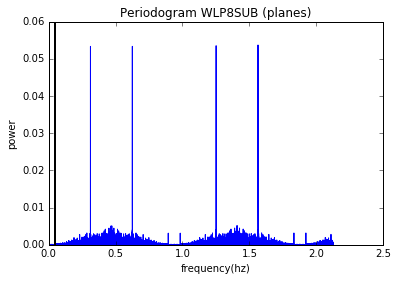

In [14]:
frequency, power = LombScargle(a1_time, av).autopower()
plt.plot(frequency, power)
hdr = fits.getheader(a1_files[5])
TINT = hdr['NGROUP']*hdr['NFRAME']*hdr['TFRAME']-(hdr['NGROUP']-1)*hdr['GROUPGAP']*hdr['TFRAME']
a = 1/(hdr['TFRAME'] + TINT)
plt.axvline(x = a, color = 'k', linewidth = 2)
plt.xlabel('frequency(hz)')
plt.ylabel('power')
plt.title('Periodogram WLP8SUB (planes)')

# Cube Series

In [35]:
def aligned_im(filename, centers, ind_ref, path_name, crop = True, just_image = False, which_image = 10):
    ref_image = rl.test_image(filename[ind_ref])[0]
    minv = np.percentile(ref_image, 20) 
    maxv = np.percentile(ref_image, 80)
    for i, fname in enumerate(filename):
        image, _, _, mask = rl.test_image(fname)
        shiftX = centers[1][i][0] - centers[1][ind_ref][0]
        shiftY = centers[2][i][0] - centers[2][ind_ref][0]
        shifted_im = ec.fshift(image, -shiftX, -shiftY)
        res_image = shifted_im - ref_image

        if (just_image == True) & (which_image == i):
            return res_image, minv, maxv
            break
        im = plt.imshow(res_image, cmap = plt.cm.YlOrBr, vmin = minv, vmax = maxv)
        plt.colorbar(im)
        plt.savefig(os.path.join(path_name, 'image%03i' % i))
        fits.writeto(path_name+('image%03i.slp.fits' % i), shifted_im, overwrite = True)
        plt.clf()

In [38]:
aligned_im(filenames_a1, centers_a1, 150, 'Cube_sub/')

In [7]:
cube = np.zeros((306,320,320))
for i in range(306):
    cube[i] = fits.getdata('Cube_sub/image%03i.slp.fits' % i)

In [8]:
med_im = np.nanmedian(cube, axis = 0)
med_im.shape

/home/rafia/anaconda2/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:739: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)


(320, 320)

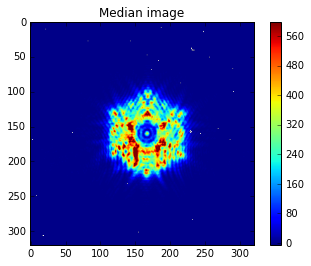

In [9]:
im = plt.imshow(med_im, vmin = -5, vmax = 600)
plt.colorbar(im)
plt.title('Median image')

In [10]:
med_cube = np.tile(med_im, (306, 1, 1))
med_cube.shape

(306, 320, 320)

In [11]:
dev_cube = (cube - med_cube)
norm_dev = dev_cube/med_cube
norm_cube = cube/med_cube
norm_cube.shape

(306, 320, 320)

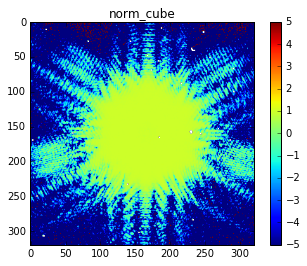

In [12]:
im = plt.imshow(norm_cube[0], vmin = -5, vmax = 5)
plt.colorbar(im)
plt.title('norm_cube')

(320, 320)


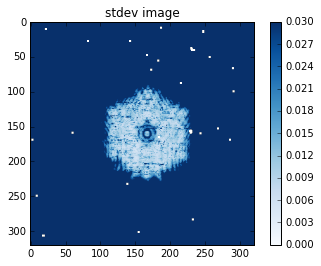

In [13]:
stdev = np.std(norm_cube, axis = 0)
print stdev.shape
im = plt.imshow(stdev, cmap = 'Blues', vmin = 0, vmax = 0.03)
plt.colorbar(im)
plt.title('stdev image')

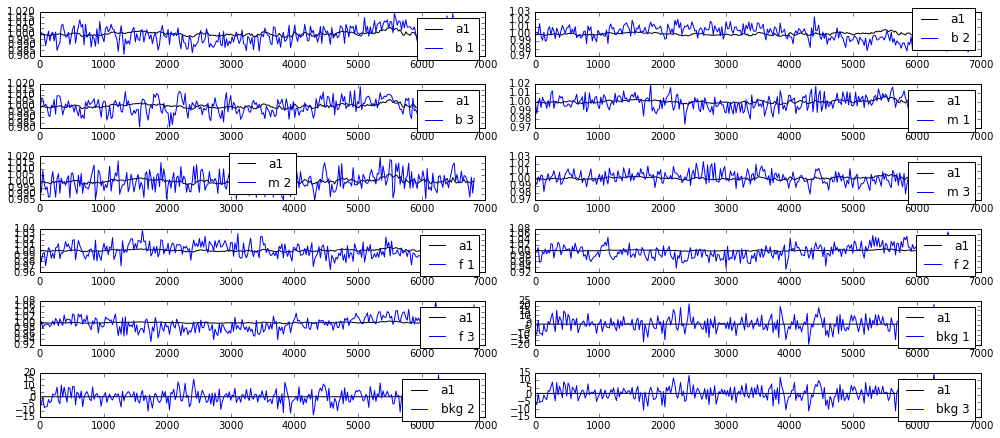

In [50]:
xvalues = [167,144,183,203,131,172,142,207,168,80,243,276]
yvalues = [132,168,181,146,165,206,134,162,170,289,74,271]
plt.figure(figsize=(14,12))
for i, (x, y) in enumerate(zip(xvalues, yvalues)):
    if i < 3:
        lbl = 'b %i' % (i+1)
    elif i < 6:
        lbl = 'm %i' % (i-2)
    elif i < 9:
        lbl = 'f %i' % (i-5)
    else:
        lbl = 'bkg %i' % (i-8)
    plt.subplot(12, 2, i+1)
    plt.plot(a1_ts['time'], a1_ts['res_flux']/np.median(a1_ts['res_flux']), 'k-', label = 'a1')
    plt.plot(a1_ts['time'], norm_cube[:, y, x], label = lbl)
    plt.legend(loc = 'best')
#     plt.suptitle('comparing time series of a single pixel through the cube')
#     plt.xlabel('time(sec)')
#     plt.ylabel('Normalized flux')
    plt.tight_layout()

In [75]:
xpos = []
ypos = []
flux = []
for x in range(320):
    for y in range(320):
        if med_im[x][y] > 600.:
            xpos.append(x)
            ypos.append(y)
            flux.append(med_im[x][y])
print len(xpos)

286


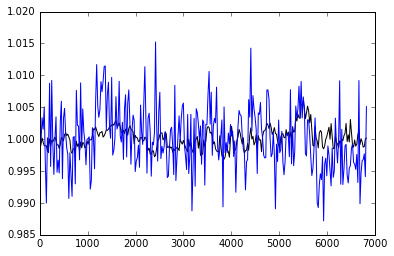

In [85]:
plt.plot(a1_ts['time'], a1_ts['res_flux']/np.median(a1_ts['res_flux']), 'k-', label = 'a1')
plt.plot(a1_ts['time'], norm_cube[:, xpos[39], ypos[39]], label = lbl)

# Error Analysis

In [14]:
rdn = fits.getdata('/usr/local/nircamsuite/cal/RN/NRCA1_17004_CDSNoise_ISIMCV3_ADU_2016-06-24.fits')

In [15]:
rdnoise = np.median(rdn)
gain = 2.2
int_time = 21.3144
noise = np.sqrt((med_im*gain*int_time)+np.square(rdnoise*gain))/(gain*int_time)

In [1]:
plt.imshow(stdev/noise)
plt.title('theoretical noise/ measured noise')

NameError: name 'plt' is not defined

In [19]:
print 'theoretical noise: ', np.nanmedian(noise)
print 'measured noise:    ', np.nanmedian(stdev)

theoretical noise:  0.36394045294
measured noise:     2.6122128121
